# Gaussian Mixture model

### Time to get your hands dirty. Black-hole binary formation channels with gaussian mixtures.

Many problems in astrophysics give rise to data with multiple modes. This is typically because different processes physical processes contribute to the observed dataset. 

For instance, one of the most outstanding question in gravitational-wave astrophysics is the formation channel of binary black holes. Leading scenarions include the evolution of isolated binaries in the galactic field and the dynamica assembly of sources in dense environments like globular clusters.

,,
Right now, state-of-the-art analyses seems to say that many channels are all at play. This is a plot by [Zevin et al (2020)](https://arxiv.org/abs/2011.10057)

where they consider 5 possibilities for the formation of black hole binaries: common envelop (CE), chemically omogenous stars (CHE), globular clusters (GC), nuclear star clusters (NSC) and stable mass transfer (SMT). 

If you want to know more about LIGO-driven astrophysics and black hole binaries formation channels, these are some recent reviews: [Mandel and Farmer (2021)](https://arxiv.org/abs/1806.05820), [Mapelli (2021)](https://arxiv.org/abs/2106.00699), [Gerosa and Fishbach (2021)](https://arxiv.org/abs/2105.03439).




Anyway. LIGO measures the masses of many black holes. You can find the dataset at `solutions/formationchannels.npy`.


*Hint*: Note that the data provided are of shape (N,1), not (N,). This might be confusing at first, but it's the format that sklearn wants (more on this in a future lecture).  A useful tool to convert between the two is [np.newaxis](https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it).

Some events form in different astrophysical environments than others. **You want to figure out how many of formation channels are at play.**


The strategy here is to fit a Gaussian Mixture model: that is, my model is a sum of $N$ gaussians each with mean $\mu_j$ and standard deviation $\sigma_j$ and weight $\alpha_j$:

$p(x_i|\theta) = \sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j) $

This depends on $3N-1$ parameters (not $3N$ because the sum of the $\alpha_j$ must be unity to ensure that this is a probability.

#### Tasks

1) Load this file (`np.load`) and complete a quick exploration of the data. How many modes do you think you see?

2) Take some time to explore `sklearn.mixture.GaussianMixture`. Check the documentation, some examples, the help menu, etc. You first need to define the model (instance of a class), and then train it on the data using the `fit` method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

*Note*. We'll do a more formal introduction to scikit-learn in one of the next lectures. This is meant to be a formative example on how you might find yourself dealing with a library you've never seen before. This happens *all the time* in scientific research!

3) Complete the fit 10 times with $N=1,...,10$ Gaussians. 

Note: `sklearn` by default will use the so-called [Expectation-Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), which is one of the many great things in data science we don't have time to study in detail.

4) For each of this fits, compute the AIC (easy! It's a attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?

5) Plot the preferred solution on top of the input data. You should get a very nice fit!

6) Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset. 

*Hint:* Useful methods here are `score_samples` and `predict_proba`: you'll need them both. Try to understand what they do and how you can put them together.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import LearningCurveDisplay
from sklearn.utils import shuffle
from sklearn.cluster import KMeans

The first thing to do is reading the data

<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_43642/1012806639.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$M_c [M_\odot]$')


(2950, 1)


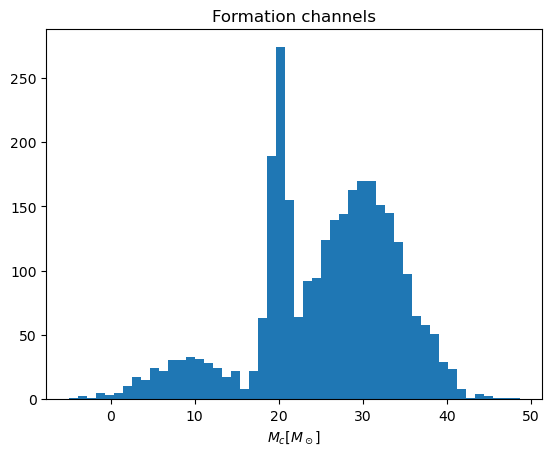

In [2]:
data = np.load('../solutions/formationchannels.npy')

print(data.shape)
plt.hist(data, bins=50)
plt.title('Formation channels')
plt.xlabel('$M_c [M_\odot]$')
plt.show()


# AIC and BIC study

Now let's train some models varying the number of components (gaussians) of the model. From the trained models I get the AIC and the BIC to study which of the models is better; it's an approximate CV process

Number of components: 3  AIC = 20083.31
Number of components: 3  BIC = 20131.23


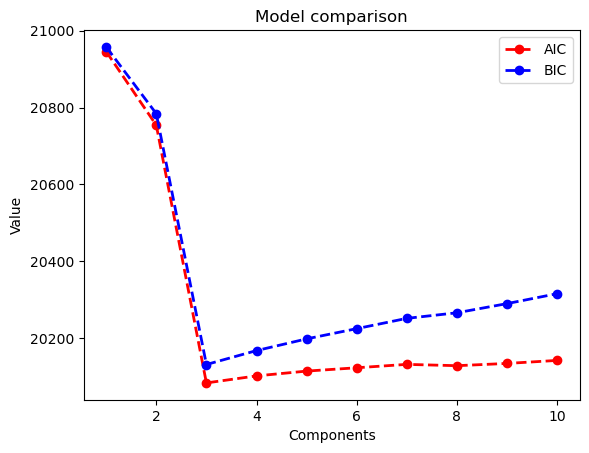

In [3]:
N = 10
AIC = []
BIC = []
gm = []
x = np.arange(1, 11, 1)
x_grid = np.linspace(np.min(data), np.max(data), len(data))

# Training the various models on the data and stack them in an array
for i in range(1, N+1):
    
    gm.append(GaussianMixture(n_components = i, random_state = 0, init_params = 'kmeans').fit(data))
    
    AIC.append(gm[i-1].aic(data))
    BIC.append(gm[i-1].bic(data))
    
# Computing the best model: the one for which the AIC (or BIC) is minimum
min_aic = np.argmin(AIC)
min_bic = np.argmin(BIC)

print('Number of components:',min_aic + 1, ' AIC = %.02f' %AIC[min_aic])
print('Number of components:',min_bic + 1, ' BIC = %.02f' %BIC[min_bic])

# Printing the AIC and the BIC, fun to show the plots 
fig = plt.figure()
plt.plot(x, AIC, color='red', lw = 2, marker = 'o', ls = '--', label = 'AIC')
plt.plot(x, BIC, color='blue', lw = 2, marker = 'o', ls = '--', label = 'BIC')
plt.title('Model comparison')
plt.xlabel('Components')
plt.ylabel('Value')
plt.legend()
plt.show()


In [4]:
# Best model 
Best = gm[min_aic]
# Just useful methods to remember, not part of the code! 
# They allow to compute the stats of the various models
# print(Best.means_)
# print(Best.covariances_)

# Bonus CV

Trying also a CV algorithm to check the result obtained with BIC and AIC. We see that the log-likelihood average (scoring for gaussian mixture)
is higher for the n = 3 components: this implies that n = 3 is the best model

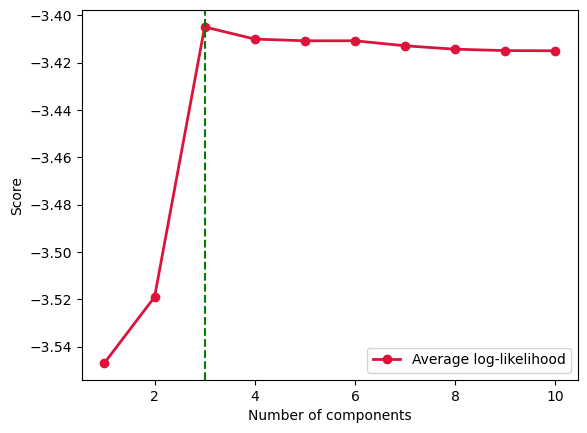

In [5]:

comps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
scores = []

# shuffleing and splitting 
cv = ShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 0)

for n in comps:
    GM = GaussianMixture(n_components = n, random_state=0, init_params = 'kmeans')
    # Array of scores of the estimator for each run of the cross validation.
    score = cross_val_score(GM, data, cv = cv)       # scoring the model 
    scores.append(np.mean(score))                    # average of the K-folds score for each model
    # each score is the avergae log-likelihood: so I'm averaging over the average log-likelihood


fig = plt.figure()
plt.plot(comps, scores, marker = 'o', lw = 2, label = 'Average log-likelihood', c = 'crimson')
plt.axvline(3, c = 'green', ls = '--')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.legend()
plt.show()

# Gaussian Mixture models

The important methods of the gaussian mixtures:


The responsibilities are the probabilities that the i data is generated by the n component of the model, it's a sort of weight associated to each point (book). Another way to see them: they are the single components of the total GM model.


Let's do some plots to understand better.

<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:31: SyntaxWarning: invalid escape sequence '\o'
<>:20: SyntaxWarning: invalid escape sequence '\o'
<>:31: SyntaxWarning: invalid escape sequence '\o'
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_43642/1571496207.py:20: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$M_c [M_{\odot}]$')
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_43642/1571496207.py:31: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$M_c [M_{\odot}]$')


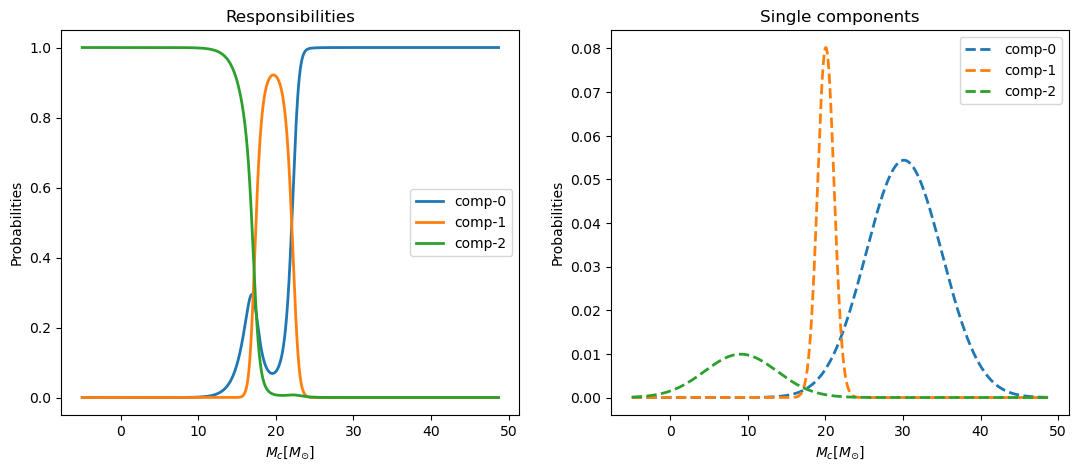

In [6]:
responsibilities = Best.predict_proba(x_grid[:, np.newaxis])
#print(responsibilities.shape)

# Log-likelihood and Likelihood of the best model
L_Best = Best.score_samples(x_grid[:, np.newaxis])
Likelihood = np.exp(L_Best)

# To reproduce the single pdfs, we need to multiply the likelihood with the
# responsibilities, in that way we are 'choosing' one distribution out of the others
single_pdf = responsibilities * Likelihood[:, np.newaxis]

# Let's look at what we are talking about!
fig = plt.figure(figsize = (13,5))

ax = fig.add_subplot(121)
ax.plot(x_grid, responsibilities[:,0], lw = 2, label = 'comp-0')
ax.plot(x_grid, responsibilities[:,1], lw = 2, label = 'comp-1')
ax.plot(x_grid, responsibilities[:,2], lw = 2, label = 'comp-2')
plt.title('Responsibilities')
plt.xlabel('$M_c [M_{\odot}]$')
plt.ylabel('Probabilities')
plt.legend()


ax = fig.add_subplot(122)
for i in range(min_aic+1):
    
    ax.plot(x_grid, single_pdf[:,i], ls = '--', lw = 2, label = 'comp-' + str(i)) 

plt.title('Single components')
plt.xlabel('$M_c [M_{\odot}]$')
plt.ylabel('Probabilities')
plt.legend()

plt.show()


<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_43642/3679329453.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$M_c [M_{\odot}]$')


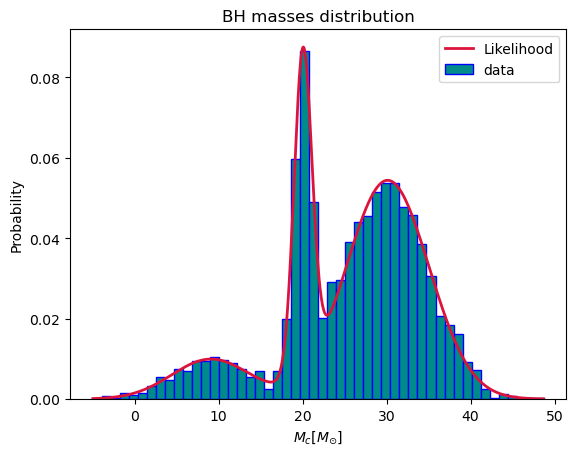

In [7]:
# Likelihood plot

fig = plt.figure()
plt.plot(x_grid, Likelihood, lw = 2, color = 'crimson', label = 'Likelihood')
plt.hist(data, bins = 50, density = True, color = 'darkcyan', edgecolor = 'blue', label = 'data')
plt.xlabel('$M_c [M_{\odot}]$')
plt.ylabel('Probability')
plt.title('BH masses distribution')
plt.legend()
plt.show()


The multigaussian model gives us a method to classify the events using probabilities and not just discrete limits taken from the figure for example

# Bonus K-Mean

I also try a K-Mean and compared the result obtained using the confusion matrix

In [8]:
from sklearn.metrics import silhouette_score
import sklearn.metrics as skm

In [9]:
s_scores = []
data_shuffled = shuffle(data)

for i in range(2, 11):

    KM = KMeans(init="k-means++", n_clusters = i, n_init = 10, random_state=0)
    KM.fit(data_shuffled)
    # Later exercises for silhouette score.
    s_scores.append(silhouette_score(data_shuffled, KM.labels_, metric = 'euclidean'))

s_scores = np.array(s_scores)


Taking the 'labels_' or taking the prediction using 'predict' is the same as long as I train and predict on the same dataset.


n_init = Number of times the k-means algorithm is run with different centroid seeds. 


The final results is the best output of n_init consecutive runs in terms of inertia. 

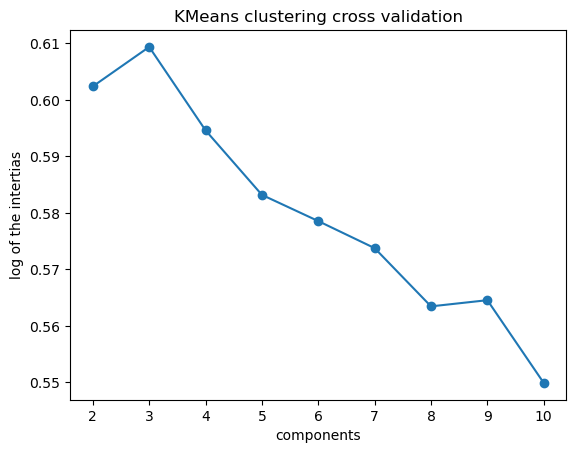

Best number of clusters: 3


In [16]:
plt.plot(np.arange(2, 11, 1), s_scores, marker = 'o')
plt.title('KMeans clustering cross validation')
plt.xlabel('components')
plt.ylabel('log of the intertias')
plt.show()

print('Best number of clusters:',np.argmax(s_scores) + 2) # two because I'm starting from n = 2!

In [13]:
KM = KMeans(init="k-means++", n_clusters = 3, n_init = 10, random_state=0)
KM.fit(data)

KMeans(n_clusters=3, n_init=10, random_state=0)

<>:9: SyntaxWarning: invalid escape sequence '\o'
<>:9: SyntaxWarning: invalid escape sequence '\o'
/var/folders/g_/40lz4w497n1gy_c45xmkxftw0000gn/T/ipykernel_43642/3530324978.py:9: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$M_c [M_{\odot}]$')


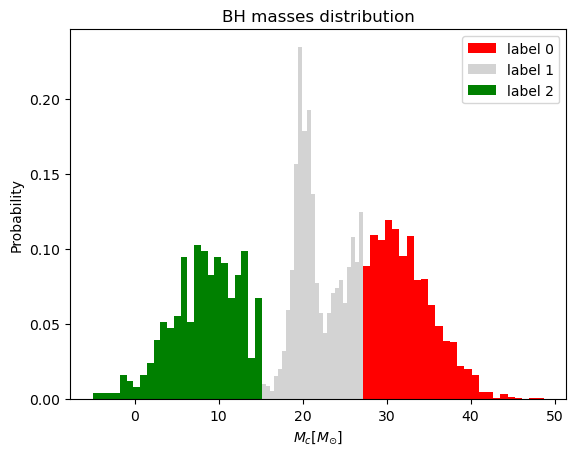

In [14]:
labels = KM.predict(data)

colors = ['red', 'lightgray', 'green']
fig = plt.figure()

for i in range(3):
    plt.hist(data[labels == i], bins = 25, density = True, label = 'label '+str(i), color = colors[i])
    
plt.xlabel('$M_c [M_{\odot}]$')
plt.ylabel('Probability')
plt.title('BH masses distribution')
plt.legend()
plt.show()


I compare the clustering made with GMM with the one of K-Means

Text(0.5, 23.52222222222222, 'KM labels')

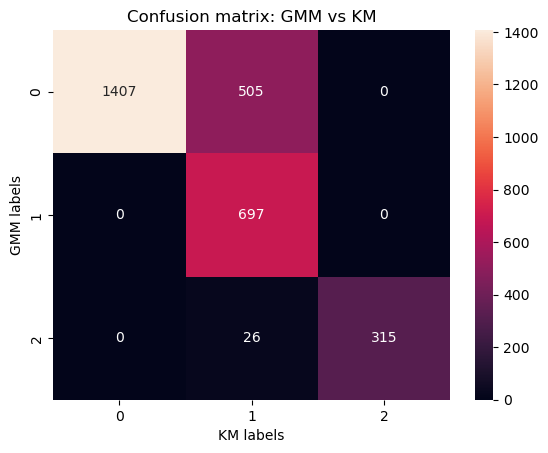

In [15]:
# Rows: true values (in this case the GMM)
# Columns: the labels of the method (KM)
# Interpretation: true value of row i but classified as column j

sns.heatmap(skm.confusion_matrix(Best.predict(data), KM.predict(data)), annot = True, fmt="d")
plt.title('Confusion matrix: GMM vs KM')
plt.ylabel('GMM labels')
plt.xlabel('KM labels')